## SP/NP Basis Modelling

This Python project seeks to build some basic statistical models for predicting the SP/NP basis. We build two models: a linear regression model and a non-linear model (such as Random Forest or Neural Network). 
In this process, we do not consider the Date/Time column in our calculations since we are not treating this as a time series. 

## Outline
The workflow of our approach is as follows:
- Data Exploration and Pre-processing: Visualize the raw input data and observe patterns in correlation. Then, pre-process the data in a reasonable manner.
- Model Building: Construct baseline linear and non-linear models to predict the peak oil production rate.
- Evaluation: Use R-Squared and RMSE to evaluate the models and compare their performance.

In [46]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import *

# Ignore warnings
warnings.simplefilter("ignore")

# Path to the training data
training_path = "./../Data/input data.xlsx"
model_save_path = "./../Saved Models/"
TARGET = "DA SPNP"

In [47]:
training_df = pd.read_excel(training_path)
training_df = training_df.dropna()
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457 entries, 0 to 457
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date/Time    457 non-null    datetime64[ns]
 1   CAISO_SOLAR  457 non-null    float64       
 2   CAISO_WIND   457 non-null    float64       
 3   NP15_LOAD    457 non-null    float64       
 4   SP15_LOAD    457 non-null    int64         
 5   NP15_THERM   457 non-null    float64       
 6   SP15_THERM   457 non-null    float64       
 7   PG&E         457 non-null    float64       
 8   SOCAL        457 non-null    float64       
 9   Malin        457 non-null    float64       
 10  DA SPNP      457 non-null    float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 42.8 KB


## Preliminary Visualization

<AxesSubplot:>

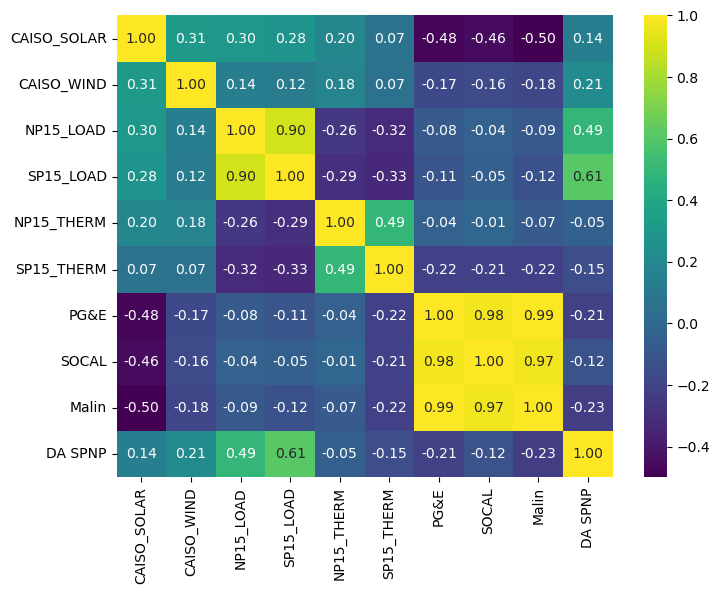

In [48]:
plt.figure(figsize=(8, 6))

# Selecting only the non-categorical variables from the DataFrame
non_categorical_data = training_df.select_dtypes(include=[np.number])
sns.heatmap(non_categorical_data.corr(), annot=True, fmt=".2f", cmap='viridis')

In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting the numeric columns (excluding the target variable 'DA SPNP' and date/time)
features = training_df.iloc[:, 1:10]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif_data

,feature,VIF
0,CAISO_SOLAR,29.648117
1,CAISO_WIND,4.772867
2,NP15_LOAD,264.618756
3,SP15_LOAD,219.261381
4,NP15_THERM,5.637585
5,SP15_THERM,4.589899
6,PG&E,157.165204
7,SOCAL,49.991374
8,Malin,104.184883


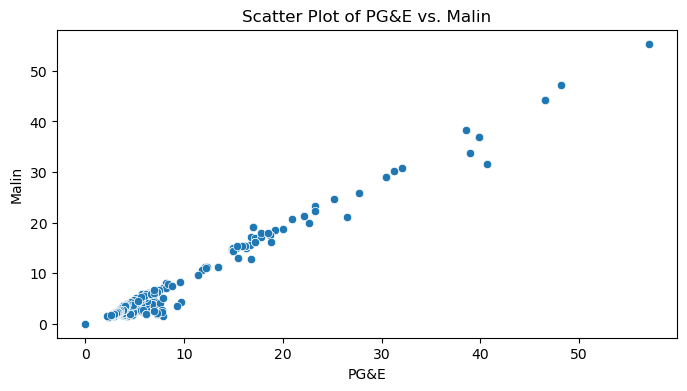

In [50]:
feature_x = 'PG&E'
feature_y = 'Malin'

# Plotting
plt.figure(figsize=(8, 4))
sns.scatterplot(data=training_df, x=feature_x, y=feature_y)
plt.title(f'Scatter Plot of {feature_x} vs. {feature_y}')
plt.xlabel(f'{feature_x}')
plt.ylabel(f'{feature_y}')
plt.show()

Due to strong multicollinearity between NP15_LOAD and SP15_LOAD, as well as multicollinearity among PG&E, Malin, and SOCAL, I will drop NP15_LOAD, Malin, and PG&E features.

In [51]:
multicoliinear_cols = ["NP15_LOAD", "Malin", "SOCAL"]
training_df = training_df.drop(columns=multicoliinear_cols)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting the numeric columns (excluding the target variable 'DA SPNP' and date/time)
features = training_df.iloc[:, 1:10]

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif_data

,feature,VIF
0,CAISO_SOLAR,30.226835
1,CAISO_WIND,4.843101
2,SP15_LOAD,28.344582
3,NP15_THERM,5.060527
4,SP15_THERM,4.717538
5,PG&E,2.700417
6,DA SPNP,1.606972


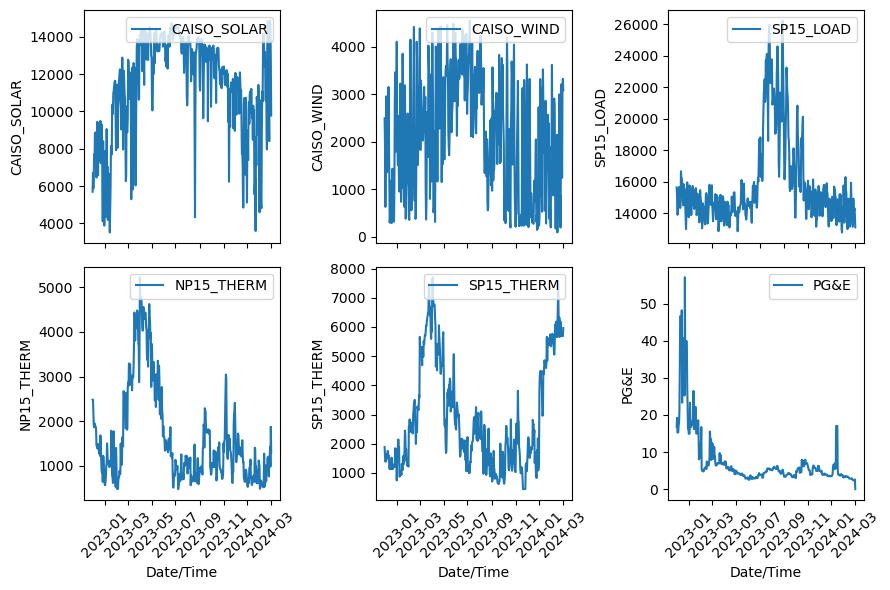

In [52]:
features = [c for c in training_df.columns if c != "Date/Time" and c != TARGET]

n_features = len(features)
n_cols = int(np.ceil(np.sqrt(n_features)))
n_rows = int(np.ceil((n_features) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharex=True)
axs = axs.flatten()

# Plotting each feature over time
for i, feature in enumerate(features):
    sns.lineplot(data=training_df, x='Date/Time', y=feature, ax=axs[i], label=feature)
    axs[i].set_ylabel(feature)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].legend(loc='upper right')

for i in range(len(features), len(axs)):
    axs[i].set_visible(False)

plt.xlabel('Date/Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

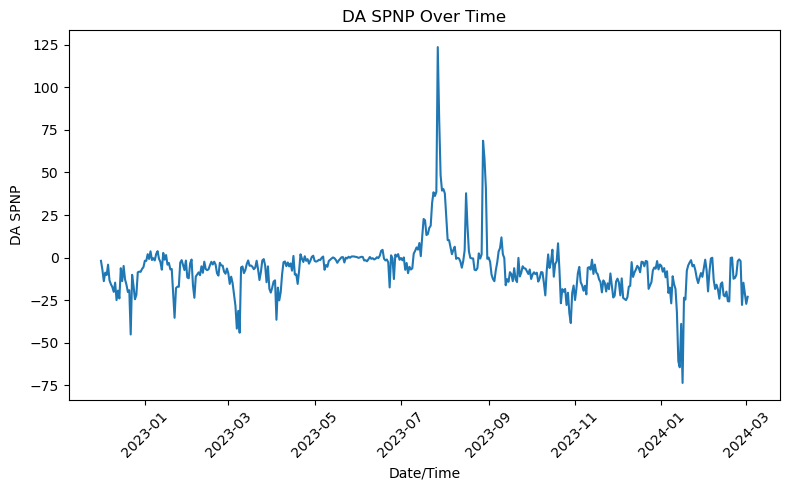

In [53]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=training_df, x='Date/Time', y=TARGET)
plt.title('DA SPNP Over Time')
plt.xlabel('Date/Time')
plt.ylabel('DA SPNP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Building

Split into training and testing datasets

In [54]:
from sklearn.model_selection import train_test_split

X = training_df.drop([TARGET], axis=1)
y = training_df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=47)
X_train = X_train.drop(columns=["Date/Time"], axis=1)
train_data = X_train.join(y_train)
test_data = X_test.join(y_test)

train_data.head()

,CAISO_SOLAR,CAISO_WIND,SP15_LOAD,NP15_THERM,SP15_THERM,PG&E,DA SPNP
354,11545.58,1272.49,15443,1279.110000,448.560000,5.755,-20.470374
301,13308.93,2909.98,16922,970.780625,847.875625,3.250,-8.121844
120,13719.72,1161.87,14303,3488.098750,6272.249375,7.080,-20.593118
310,13383.10,292.13,18961,1349.955000,2098.891875,5.645,-12.253779
253,13253.89,3552.47,19604,719.048125,972.325625,5.580,-0.544276


### Linear Regression

In [55]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Scale the input data
scaler = StandardScaler()
x_train, y_train = train_data.drop([TARGET], axis=1), train_data[TARGET]
X_train_s = scaler.fit_transform(x_train)

X_dates = test_data["Date/Time"]
X_test_no_date = X_test.drop(["Date/Time"], axis=1)
X_test_no_date_s = scaler.transform(X_test_no_date) 

# Fit a Lasso Regression model
alpha = 0.05
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_s, y_train)

Lasso(alpha=0.05)

In [56]:
lasso_score = round(lasso_reg.score(X_test_no_date_s, y_test), 3)
lasso_score

0.37

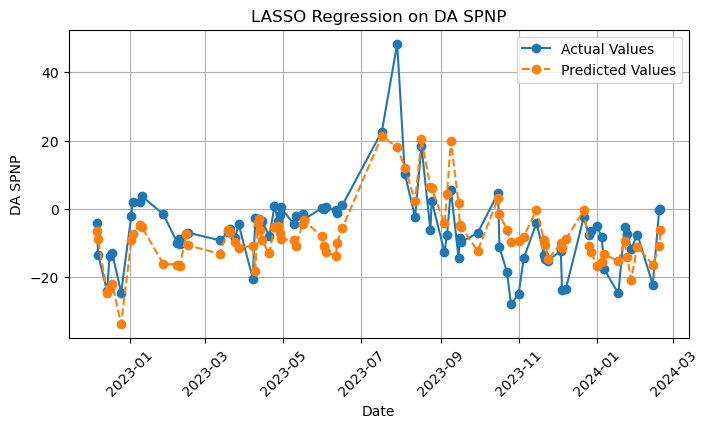

In [57]:
def plot_predictions(model, X_test, y_test, title):
    y_pred = model.predict(X_test)

    result_df = pd.DataFrame()
    result_df['Date'] = X_dates
    result_df['Actual'] = y_test
    result_df['Predicted'] = y_pred
    result_df = result_df.sort_values(by='Date')

    plt.figure(figsize=(8, 4))
    plt.plot(result_df['Date'], result_df['Actual'], label='Actual Values', marker='o', linestyle='-')
    plt.plot(result_df['Date'], result_df['Predicted'], label='Predicted Values', marker='o', linestyle='--')
    plt.xlabel('Date')
    plt.title(title)
    plt.ylabel(TARGET)
    plt.legend()
    plt.xticks(rotation=45) 
    plt.grid(True)

    return plt

plot_lasso = plot_predictions(lasso_reg, X_test_no_date_s, y_test, "LASSO Regression on " + TARGET)
plot_lasso.show()

### Random Forest Regression

In [58]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [59]:
forest_score = round(forest.score(X_test_no_date_s, y_test), 3)
forest_score

0.578

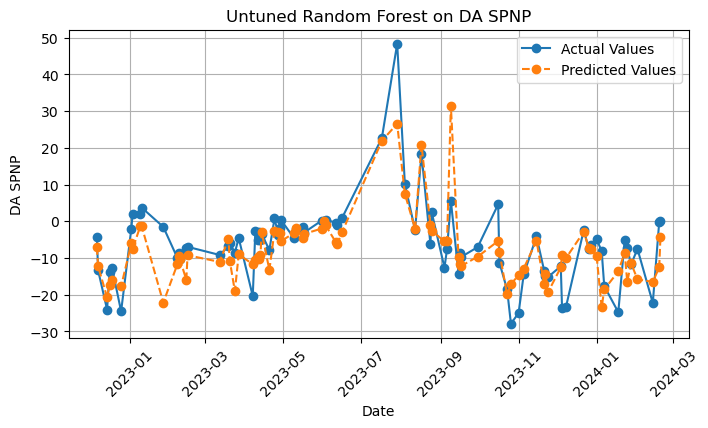

In [60]:
plot_rf = plot_predictions(forest, X_test_no_date_s, y_test, "Untuned Random Forest on " + TARGET)
plot_rf.show()

### Tuned Random Forest

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 50],  
    "max_features": ['auto', 0.4],  
    "max_depth": [None, 10],  
    "min_samples_split": [2, 5],  
    "min_samples_leaf": [1, 2],  
}
grid_search = GridSearchCV(forest, param_grid, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10], 'max_features': ['auto', 0.4],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 50]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [62]:
best_forest = grid_search.best_estimator_
best_forest

RandomForestRegressor(min_samples_leaf=2, n_estimators=50)

In [63]:
best_forest_score = round(best_forest.score(X_test_no_date_s, y_test), 3)
best_forest_score

0.589

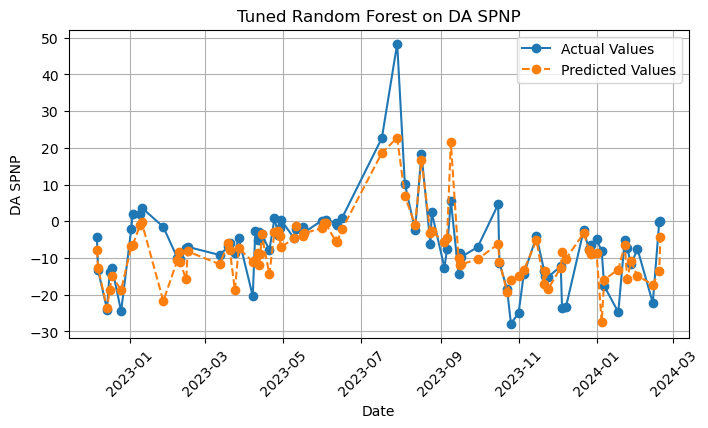

In [64]:
plot_best_rf = plot_predictions(best_forest, X_test_no_date_s, y_test, "Tuned Random Forest on " + TARGET)
plot_best_rf.show()

In [65]:
best_forest.feature_importances_

array([0.08618149, 0.04587066, 0.53723762, 0.12137813, 0.08149915,
       0.12783295])

### Save the Tuned Random Forest to a pickle file

In [66]:
import pickle

with open(model_save_path + "random_forest_model.pkl", 'wb') as f:
    pickle.dump(best_forest, f)